---

* 출처: LangChain 공식 문서 또는 해당 교재명
* 원본 URL: https://smith.langchain.com/hub/teddynote/summary-stuff-documents

---

### **9. `TimeWeightedVectorStoreRetriever`**

#### **1) `시간 가중 벡터저장소 검색기`**

* **`TimeWeightedVectorStoreRetriever`**

  * `의미론적 유사성`과 `시간에 따른 감쇠`를 결합해 사용하는 검색 도구

  * 문서 또는 데이터의 **`신선함`** 과 **`관련성`** 을 모두 고려하여 결과를 제공

* **`스코어링 알고리즘`**

  * 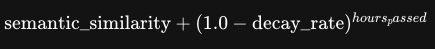

  * `semantic_similarity` = 문서 or 데이터 간의 의미적 유사도
  * `decay_rate` = 시간이 지남에 따라 점수가 얼마나 감소하는지를 나타내는 비율
  * `hours_passed` = 객체가 마지막으로 접근한 후 부터 현재까지 경과한 시간 *(시간 단위)*

* 주요 특징

  * 객체가 마지막으로 접근된 시간을 기준 = **`정보의 신선함`** 평가
  * **`자주 접근되는 객체 = 시간이 지나도 높은 점수 유지` → `자주 사용되거나 중요하게 여겨지는 정보가 상위에 위치할 가능성 ↑`**
  * **`동적인 검색 결과 제공`**: 최신성, 관련성을 모두 고려함

* **`decay_rate`**

  * **≠ `retriever의 객체가 생성된 이후`**

  * **= `마지막으로 액세스된 이후 경과된 시간`**

  * **`자주 액세스하는 객체 = 최신으로 유지`**

---

#### **2) `설정`**

In [ ]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()                               # True

In [ ]:
from langsmith import Client
from langsmith import traceable

import os

# LangSmith 환경 변수 확인

print("\n--- LangSmith 환경 변수 확인 ---")
langchain_tracing_v2 = os.getenv('LANGCHAIN_TRACING_V2')
langchain_project = os.getenv('LANGCHAIN_PROJECT')
langchain_api_key_status = "설정됨" if os.getenv('LANGCHAIN_API_KEY') else "설정되지 않음" # API 키 값은 직접 출력하지 않음

if langchain_tracing_v2 == "true" and os.getenv('LANGCHAIN_API_KEY') and langchain_project:
    print(f"✅ LangSmith 추적 활성화됨 (LANGCHAIN_TRACING_V2='{langchain_tracing_v2}')")
    print(f"✅ LangSmith 프로젝트: '{langchain_project}'")
    print(f"✅ LangSmith API Key: {langchain_api_key_status}")
    print("  -> 이제 LangSmith 대시보드에서 이 프로젝트를 확인해 보세요.")
else:
    print("❌ LangSmith 추적이 완전히 활성화되지 않았습니다. 다음을 확인하세요:")
    if langchain_tracing_v2 != "true":
        print(f"  - LANGCHAIN_TRACING_V2가 'true'로 설정되어 있지 않습니다 (현재: '{langchain_tracing_v2}').")
    if not os.getenv('LANGCHAIN_API_KEY'):
        print("  - LANGCHAIN_API_KEY가 설정되어 있지 않습니다.")
    if not langchain_project:
        print("  - LANGCHAIN_PROJECT가 설정되어 있지 않습니다.")

<small>

* 셀 출력

  ```markdown
  --- LangSmith 환경 변수 확인 ---
  ✅ LangSmith 추적 활성화됨 (LANGCHAIN_TRACING_V2='true')
  ✅ LangSmith 프로젝트: 'LangChain-prantice'
  ✅ LangSmith API Key: 설정됨
    -> 이제 LangSmith 대시보드에서 이 프로젝트를 확인해 보세요.
  ```

---

#### **3) `낮은 감쇠율` (`low decay_rate`)**

* 낮은 감쇠율의 의미

  * **`decay rate`가 낮다는 것** = 기억이 **`더 오래 기억될 것`임을 의미**

  * **`decay rate` = 0**
    * **`기억이 절대 잊혀지지 않는다는 것`을 의미**
    * 이 `retriever`를 `vector lookup`과 동등하게 만듦

* **`TimeWeightedVectorStoreRetriever`** 초기화

  * `벡터 저장소`, 감쇠율(`decay_rate`)을 매우 작은 값으로 설정(`여기에서는 0`)
  * 검색할 벡터의 개수(`k`)를 1로 지정

In [7]:
from datetime import datetime, timedelta

import faiss
from langchain.docstore import InMemoryDocstore
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
#from langchain_core.embeddings import FakeEmbeddings

import warnings

# 경고 무시
warnings.filterwarnings("ignore")

# 임베딩 사용하기 (try_1)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
    )

print("✅ hugging-face 임베딩 모델 로딩 완료!")


# 768차원 임베딩 불러오기 (try_2)
"""
embeddings2 = HuggingFaceEmbeddings(
                model_name="sentence-transformers/all-mpnet-base-v2",   # 768차원
                model_kwargs={'device': 'cpu'},
                encode_kwargs={'normalize_embeddings': True})

embeddings = embeddings2
"""

# fake huggingface 임베딩 (1536) (try_3)
"""
embeddings3 = FakeEmbeddings(size=1536)

embeddings = embeddings3
"""

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ hugging-face 임베딩 모델 로딩 완료!


'\nembeddings3 = FakeEmbeddings(size=1536)\n\nembeddings = embeddings3                                                  # 3.2s\n'

<small>

* 설치 과정 및 결과
  * 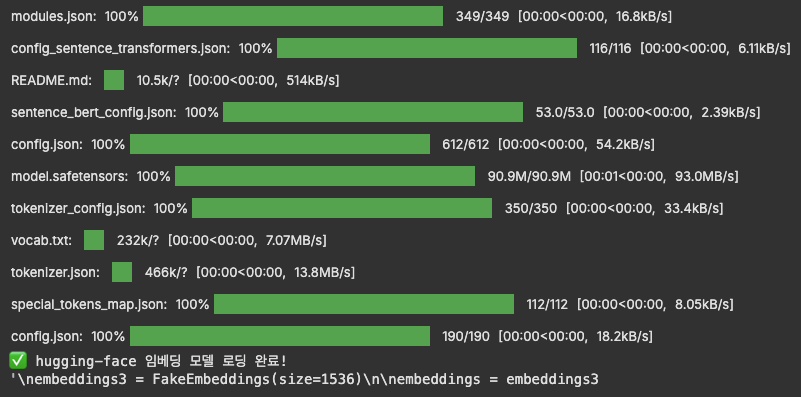

* ✅ hugging-face 임베딩 모델 로딩 완료!

In [8]:
dimension_size = len(embeddings.embed_query("hello world"))
print(dimension_size)
print("✅ fake hugginsface 임베딩 차원 확인 완료!")

384
✅ fake hugginsface 임베딩 차원 확인 완료!


<small>

* 384
* ✅ fake hugginsface 임베딩 차원 확인 완료!

In [9]:
# FAISS 인덱스는 임베딩 모델의 출력 차원과 일치해야 함
embedding_size = 384

# FAISS 인덱스 생성
index = faiss.IndexFlatL2(embedding_size)

# FAISS 벡터 저장소 초기화
vectorstore = FAISS(
    embeddings,
    index,                        # FAISS 인덱스
    InMemoryDocstore({}),         # 초기에는 비어있는 Docstore
    {},                           # Index to docstore ID 맵핑 (초기에는 비어 있음)
)

In [10]:
# 시간 가중치가 적용된 벡터 저장소 검색기를 초기화하기

retriever = TimeWeightedVectorStoreRetriever(
    vectorstore=vectorstore,
    decay_rate=0.0000000000000000000000001,                 # 낮은 감쇠율 적용
    k=1                                                     # k = 1
)

* 간단한 예제 데이터 추가해보기

In [11]:
# 어제 날짜 계산해보기
yesterday = datetime.now() - timedelta(days=1)
print(yesterday)                                          # 2025-10-02 01:29:41.959180

2025-10-02 01:29:41.959180


In [13]:
print(index.d)            # FAISS 인덱스의 차원 확인
# 384

384


In [14]:
retriever.add_documents(
    [
        Document(
            page_content="어제 날짜를 설정해 추가합니다.",         # 문서 추가하기
            metadata={"last_accessed_at": yesterday},       # 어제 날짜 설정
        )
    ]
)                               # ['c92a51f4-b6e1-4014-a66b-33a78e0dc262']

['c92a51f4-b6e1-4014-a66b-33a78e0dc262']

In [15]:
# 다른 문서를 추가하기

retriever.add_documents(
    [
        Document(
            page_content="어제 날짜는요?"
            # metadata = 별도로 설정하지 않음
            )])                 # ['c8df1817-e43a-4b97-abbe-00b4f3a7b6f0']

['c8df1817-e43a-4b97-abbe-00b4f3a7b6f0']

* **`retriever.invoke()`** 호출 → 검색 수행하기

  * 가장 두드러진 (`salient`) 문서이기 때문
  * **`decay_rate`** **`→ 0에 가깝기 때문`** 에 문서는 여전히 최신(`recent`)으로 간주됨

In [16]:
retriever.invoke("어제 날짜")

[Document(metadata={'last_accessed_at': datetime.datetime(2025, 10, 3, 1, 30, 20, 338939), 'created_at': datetime.datetime(2025, 10, 3, 1, 30, 8, 130345), 'buffer_idx': 1}, page_content='어제 날짜는요?')]

<small>

* 낮은 감쇠율 출력

  ```python
  [Document(metadata={'last_accessed_at': datetime.datetime(2025, 10, 3, 1, 30, 20, 338939), 'created_at': datetime.datetime(2025, 10, 3, 1, 30, 8, 130345), 'buffer_idx': 1}, page_content='어제 날짜는요?')]
  ```

#### **4) `높은 감쇠율` (`high decay_rate`)**

* 높은 **`decay_rate` 사용 시 = `recency score` 빠르게 `0`으로 수렴**
  * *예시: `decay_rate` = 0.9999...*
  * 만약 `decay_rate` = 1 → 모든 객체의 `recency`값 = `0` → `Vector Lookup`과 동일한 결과

* **`TimeWeightedVectorStorRetriever`** 사용 → 검색기 초기화

  * `decay_rate` = `0.999` → *시간에 따른 가중치 감소율 조정*

In [17]:
# 임베딩 모델 정의하기
import warnings

# 경고 무시
warnings.filterwarnings("ignore")

# 임베딩 사용하기 (try_1)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
    )

print("✅ hugging-face 임베딩 모델 로딩 완료!")

✅ hugging-face 임베딩 모델 로딩 완료!


<small>

* ✅ hugging-face 임베딩 모델 로딩 완료!

In [18]:
# 벡터 저장소 초기화하기
embedding_size = 384

# FAISS 인덱스 생성
index = faiss.IndexFlatL2(embedding_size)

# FAISS 벡터 저장소 초기화
vectorstore = FAISS(
    embeddings,
    index,                        # FAISS 인덱스
    InMemoryDocstore({}),         # 초기에는 비어있는 Docstore
    {},                           # Index to docstore ID 맵핑 (초기에는 비어 있음)
)

In [19]:
# 시간가중치가 적용된 벡터저장소 검색기 초기화하기

retriever = TimeWeightedVectorStoreRetriever(
    vectorstore=vectorstore,
    decay_rate=0.999,                                       # 높은 감쇠율 적용
    k=1                                                     # k = 1
)

* 다시 문서를 새롭게 추가하기

In [20]:
# 어제 날짜 계산해보기
yesterday = datetime.now() - timedelta(days=1)
print(yesterday)                                            # 2025-10-02 01:43:09.683966

2025-10-02 01:43:09.683966


In [21]:
# 문서 추가 및 메타데이터에 어제 날짜 추가하기
retriever.add_documents(
    [
        Document(
            page_content="어제 날짜를 설정해 추가합니다.",         # 문서 추가하기
            metadata={"last_accessed_at": yesterday},       # 어제 날짜 설정
        )
    ]
)                                                           # ['89f7ca8d-2ab0-48fa-991f-bc6e7aae6bfc']

['89f7ca8d-2ab0-48fa-991f-bc6e7aae6bfc']

In [22]:
# 다른 문서 추가하기
retriever.add_documents(
    [
        Document(
            page_content="어제 날짜는요?"
            # metadata = 별도로 설정하지 않음
            )])                                             # ['9a6466d8-58c3-4e0a-9027-7c8c604a6977']

['9a6466d8-58c3-4e0a-9027-7c8c604a6977']

* **`retriever.invoke()`** 호출해보기

In [23]:
retriever.invoke("어제 날짜")

[Document(metadata={'last_accessed_at': datetime.datetime(2025, 10, 3, 1, 45, 44, 33873), 'created_at': datetime.datetime(2025, 10, 3, 1, 44, 40, 312475), 'buffer_idx': 1}, page_content='어제 날짜는요?')]

<small>

* 높은 감쇠율 출력

  ```python
  [Document(metadata={'last_accessed_at': datetime.datetime(2025, 10, 3, 1, 45, 44, 33873), 'created_at': datetime.datetime(2025, 10, 3, 1, 44, 40, 312475), 'buffer_idx': 1}, page_content='어제 날짜는요?')]
  ```

  * **`'어제 날짜는요?'` 가 먼저 반환**
  * **`retriever` → `어제 날짜를 설정해 추가합니다` 와 관련된 문서를 대부분 잊어버렸기 때문**

---

* **`감쇠율` (`decay_rate`) 정리**

  * `decay_rate` = `0.000001` *→ 매우 작게 설정한 경우*
    * 감쇠율 (**`= 정보를 망각하는 비율`**)이 매우 낮음 → **정보를 거의 잊지 않음**
    * **`최신 정보이든 오래된 정보이든 시간 가중치 차이가 거의 없음` → `이런 경우 유사도에 더 높은 점수를 주게 됨`**

  * `decay_rate` = `0.999` *→ 1에 가깝게 설정한 경우*
    * 감쇠율 (**`= 정보를 망각하는 비율`**)이 매우 높음 → **과거의 정보를 거의 다 잊어버림**
    * **`최신 정보에 더 높은 점수를 주게 됨`**

---

#### **5) `가상의 시간으로 decay_rate` 조정**

* `LangChain`의 일뷰 유틸리티 사용 → 시간 구성 요소를 모의(`mock`) 테스트 가능

  * **`mock_now`**
    * `LangChain`에서 제공하는 유틸리티 함수
    * 현재 시간을 모의(`moke`)하는 데 사용

In [24]:
import datetime
from langchain.utils import mock_now

# 현재 시간을 특정 시점으로 설정
mock_now(datetime.datetime(2024, 8, 30, 00, 00))

# 현재 시간 출력
print(datetime.datetime.now())                    # 2025-10-03 01:56:28.768333

2025-10-03 01:56:28.768333


* **`mock_now`** 함수 사용
  * 현재 시간 변경하면서 검색 결과 테스트 가능
  * 해당 기능 활용해 적절한 `decay_rate` 찾는데 도움을 받을 수 있음

* *주의: 만약 너무 오래전의 시간으로 설정하면, `decay_rate` 계산 시 오류가 발생할 수 있음*

In [27]:
# 현재 시간을 임의의 시간으로 변경하기

with mock_now(datetime.datetime(2025, 10, 2, 00, 00)):
    # 변경된 시점에서 문서를 검색하기
    print(retriever.invoke("어제 날짜"))


[Document(metadata={'last_accessed_at': MockDateTime(2025, 10, 2, 0, 0), 'created_at': datetime.datetime(2025, 10, 3, 1, 44, 40, 312475), 'buffer_idx': 1}, page_content='어제 날짜는요?')]


<small>

* **`moco_now`** 사용한 결과

  ```python
  [Document(metadata={'last_accessed_at': MockDateTime(2025, 10, 2, 0, 0), 'created_at': datetime.datetime(2025, 10, 3, 1, 44, 40, 312475), 'buffer_idx': 1}, page_content='어제 날짜는요?')]
  ```

---

* *next: **`10. 한글 형태소 분석기(Kiwi, Kkma, Okt) + BM25 검색기`***

---